# Lecture 10


# Combining Datasets: Concat and Append

Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets, to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
``Series`` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

Here we'll take a look at simple concatenation of ``Series`` and ``DataFrame``s with the ``pd.concat`` function; later we'll dive into more sophisticated in-memory merges and joins implemented in Pandas.


For convenience, we'll define this function which creates a ``DataFrame`` of a particular form that will be useful below:

In [68]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special ``_repr_html_`` method, which IPython uses to implement its rich object display:

In [69]:
eval("2 + 3 * len('hello')")

17

In [168]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

The use of this will become clearer as we continue our discussion in the following section.

## Recall: Concatenation of NumPy Arrays

Concatenation of ``Series`` and ``DataFrame`` objects is very similar to concatenation of Numpy arrays, which can be done via the ``np.concatenate`` function:

In [71]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
np.concatenate([x, y, z])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The first argument is a list or tuple of arrays to concatenate.
Additionally, it takes an ``axis`` keyword that allows you to specify the axis along which the result will be concatenated:

In [72]:
x = [[1, 2],
     [3, 4]]
np.concatenate([x, x], axis=1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

## Simple Concatenation with ``pd.concat``

Pandas has a function, ``pd.concat()``, which has a similar syntax to ``np.concatenate`` but contains a number of options that we'll discuss momentarily:

```python
# Signature in Pandas v0.18
pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
```

``pd.concat()`` can be used for a simple concatenation of ``Series`` or ``DataFrame`` objects, just as ``np.concatenate()`` can be used for simple concatenations of arrays:

In [75]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

It also works to concatenate higher-dimensional objects, such as ``DataFrame``s:

In [169]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
display('df1', 'df2', 'pd.concat([df1, df2])')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


By default, the concatenation takes place row-wise within the ``DataFrame`` (i.e., ``axis=0``).
Like ``np.concatenate``, ``pd.concat`` allows specification of an axis along which concatenation will take place.
Consider the following example:

In [95]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis='columns')")

We could have equivalently specified ``axis=1``; here we've used the more intuitive ``axis='columns``. 

### Duplicate indices

One important difference between ``np.concatenate`` and ``pd.concat`` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this simple example:

In [96]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result.
While this is valid within ``DataFrame``s, the outcome is often undesirable.
``pd.concat()`` gives us a few ways to handle it.

#### Catching the repeats as an error

If you'd like to simply verify that the indices in the result of ``pd.concat()`` do not overlap, you can specify the ``verify_integrity`` flag.
With this set to True, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

In [97]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the ``ignore_index`` flag.
With this set to true, the concatenation will create a new integer index for the resulting ``Series``:

In [98]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys

Another option is to use the ``keys`` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data:

In [99]:
display('x', 'y', "pd.concat([x, y], keys=['x', 'y'])")

The result is a multiply indexed ``DataFrame``

### Concatenation with joins

In the simple examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and ``pd.concat`` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

In [100]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

By default, the entries for which no data is available are filled with NA values.
To change this, we can specify one of several options for the ``join`` parameters of the concatenate function.
By default, the join is a union of the input columns (``join='outer'``), but we can change this to an intersection of the columns using ``join='inner'``:

In [101]:
display('df5', 'df6',
        "pd.concat([df5, df6], join='inner')")

### The ``append()`` method

Because direct array concatenation is so common, ``Series`` and ``DataFrame`` objects have an ``append`` method that can accomplish the same thing in fewer keystrokes.
For example, rather than calling ``pd.concat([df1, df2])``, you can simply call ``df1.append(df2)``:

In [103]:
display('df1', 'df2', 'df1.append(df2)')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


Keep in mind that unlike the ``append()`` and ``extend()`` methods of Python lists, the ``append()`` method in Pandas does not modify the original object–instead it creates a new object with the combined data.
It also is not a very efficient method, because it involves creation of a new index *and* data buffer.
Thus, if you plan to do multiple ``append`` operations, it is generally better to build a list of ``DataFrame``s and pass them all at once to the ``concat()`` function.

In the next section, we'll look at another more powerful approach to combining data from multiple sources, the database-style merges/joins implemented in ``pd.merge``.


# Combining Datasets: Merge and Join

One essential feature offered by Pandas is its high-performance, in-memory join and merge operations.
If you have ever worked with databases, you should be familiar with this type of data interaction.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.

For convenience, we will start by redefining the ``display()`` functionality from the previous section:

## Relational Algebra

The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

## Categories of Joins

The ``pd.merge()`` function implements a number of types of joins: the *one-to-one*, *many-to-one*, and *many-to-many* joins.
All three types of joins are accessed via an identical call to the ``pd.merge()`` interface; the type of join performed depends on the form of the input data.
Here we will show simple examples of the three types of merges, and discuss detailed options further below.

### One-to-one joins

Perhaps the simplest type of merge expresion is the one-to-one join, which is in many ways very similar to the column-wise concatenation.
As a concrete example, consider the following two ``DataFrames`` which contain information on several employees in a company:

In [104]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2')

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Jake,2012
3,Sue,2014


To combine this information into a single ``DataFrame``, we can use the ``pd.merge()`` function:

In [105]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


The ``pd.merge()`` function recognizes that each ``DataFrame`` has an "employee" column, and automatically joins using this column as a key.
The result of the merge is a new ``DataFrame`` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "employee" column differs between ``df1`` and ``df2``, and the ``pd.merge()`` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the ``left_index`` and ``right_index`` keywords).

### Many-to-one joins

Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting ``DataFrame`` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

In [108]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

The resulting ``DataFrame`` has an aditional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs.

### Many-to-many joins

Many-to-many joins are a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a ``DataFrame`` showing one or more skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any individual person:

In [110]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,coding
3,Engineering,linux
4,HR,spreadsheets


These three types of joins can be used with other Pandas tools to implement a wide array of functionality.
But in practice, datasets are rarely as clean as the one we're working with here.
In the following section we'll consider some of the options provided by ``pd.merge()`` that enable you to tune how the join operations work.

## Specification of the Merge Key

We've already seen the default behavior of ``pd.merge()``: it looks for one or more matching column names between the two inputs, and uses this as the key.
However, often the column names will not match so nicely, and ``pd.merge()`` provides a variety of options for handling this.

### The ``on`` keyword

Most simply, you can explicitly specify the name of the key column using the ``on`` keyword, which takes a column name or a list of column names:

In [111]:
display('df1', 'df2', "pd.merge(df1, df2, on='employee')")

This option works only if both the left and right ``DataFrame``s have the specified column name.

### The ``left_on`` and ``right_on`` keywords

At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee name is labeled as "name" rather than "employee".
In this case, we can use the ``left_on`` and ``right_on`` keywords to specify the two column names:

In [114]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on="employee", right_on="name")')

The result has a redundant column that we can drop if desired–for example, by using the ``drop()`` method of ``DataFrame``s:

In [115]:
pd.merge(df1, df3, left_on="employee", right_on="name").drop('name', axis=1)

,employee,group,salary
0,Bob,Accounting,70000
1,Jake,Engineering,80000
2,Lisa,Engineering,120000
3,Sue,HR,90000


### The ``left_index`` and ``right_index`` keywords

Sometimes, rather than merging on a column, you would instead like to merge on an index.
For example, your data might look like this:

In [116]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


You can use the index as the key for merging by specifying the ``left_index`` and/or ``right_index`` flags in ``pd.merge()``:

In [119]:
display('df1a', 'df2a',
        "pd.merge(df1a, df2a, left_index=True, right_index=True)")

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


For convenience, ``DataFrame``s implement the ``join()`` method, which performs a merge that defaults to joining on indices:

In [120]:
display('df1a', 'df2a', 'df1a.join(df2a)')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


If you'd like to mix indices and columns, you can combine ``left_index`` with ``right_on`` or ``left_on`` with ``right_index`` to get the desired behavior:

In [121]:
display('df1a', 'df3', "pd.merge(df1a, df3, left_index=True, right_on='name')")

All of these options also work with multiple indices and/or multiple columns; the interface for this behavior is very intuitive.
For more information on this, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

## Specifying Set Arithmetic for Joins

In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.
This comes up when a value appears in one key column but not the other. Consider this example:

In [122]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

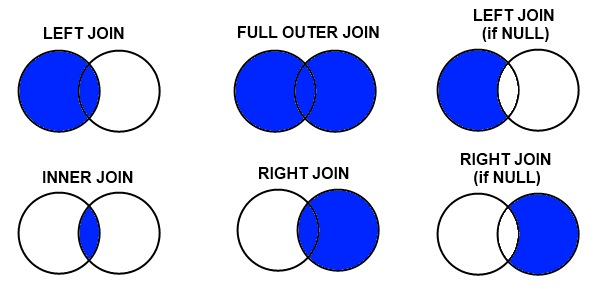

Here we have merged two datasets that have only a single "name" entry in common: Mary.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the ``how`` keyword, which defaults to ``"inner"``:

In [123]:
pd.merge(df6, df7, how='inner')

,name,food,drink
0,Mary,bread,wine


Other options for the ``how`` keyword are ``'outer'``, ``'left'``, and ``'right'``.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

In [124]:
display('df6', 'df7', "pd.merge(df6, df7, how='outer')")

The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

In [125]:
display('df6', 'df7', "pd.merge(df6, df7, how='left')")

The output rows now correspond to the entries in the left input. Using
``how='right'`` works in a similar manner.

All of these options can be applied straightforwardly to any of the preceding join types.

In [126]:
display('df6', 'df7', "pd.merge(df6, df7, how='right')")

## Overlapping Column Names: The ``suffixes`` Keyword

Finally, you may end up in a case where your two input ``DataFrame``s have conflicting column names.
Consider this example:

In [127]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

Because the output would have two conflicting column names, the merge function automatically appends a suffix ``_x`` or ``_y`` to make the output columns unique.
If these defaults are inappropriate, it is possible to specify a custom suffix using the ``suffixes`` keyword:

In [128]:
display('df8', 'df9', 'pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])')

These suffixes work in any of the possible join patterns, and work also if there are multiple overlapping columns.

Also see the [Pandas "Merge, Join and Concatenate" documentation](http://pandas.pydata.org/pandas-docs/stable/merging.html) for further discussion of these topics.

## Example: US States Data

Merge and join operations come up most often when combining data from different sources.
Here we will consider an example of some data about US states and their populations.

In [ ]:
# Following are shell commands to download the data
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-areas.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-abbrevs.csv

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [129]:
pop = pd.read_csv('D:\Света\Фреймворки пайтон\Лекции\lect_10\state-population.csv')
areas = pd.read_csv('D:\Света\Фреймворки пайтон\Лекции\lect_10\state-areas.csv')
abbrevs = pd.read_csv('D:\Света\Фреймворки пайтон\Лекции\lect_10\state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

Given this information, say we want to compute a relatively straightforward result: rank US states and territories by their 2010 population density.
We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.
We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.
We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

In [132]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged.head()

,state/region,ages,year,population,state,abbreviation
0,AL,under18,2012,1117489.0,Alabama,AL
1,AL,total,2012,4817528.0,Alabama,AL
2,AL,under18,2010,1130966.0,Alabama,AL
3,AL,total,2010,4785570.0,Alabama,AL
4,AL,under18,2011,1125763.0,Alabama,AL


In [134]:
merged = merged.drop('abbreviation',1) # drop duplicate info, 1 is an axis
merged.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

In [136]:
merged.isna().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

Some of the ``population`` info is null; let's figure out which these are!

In [137]:
merged[merged['population'].isna()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [138]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [139]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the area data using a similar procedure.
Examining our results, we will want to join on the ``state`` column in both:

In [156]:
final = pd.merge(merged, areas, on='state', how='left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Again, let's check for nulls to see if there were any mismatches:

In [157]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [158]:
final['state'][final['area (sq. mi)'].isnull()].unique()


array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [159]:
final.dropna(inplace=True)
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2000, and the total population.
We'll use the ``query()`` function to do this quickly:

In [160]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state, and then compute the result:

In [162]:
data2010.set_index('state', inplace=True)
data2010.head()

,state/region,ages,year,population,area (sq. mi)
state,,,,,
Alabama,AL,total,2010,4785570.0,52423.0
Alaska,AK,total,2010,713868.0,656425.0
Arizona,AZ,total,2010,6408790.0,114006.0
Arkansas,AR,total,2010,2922280.0,53182.0
California,CA,total,2010,37333601.0,163707.0


In [163]:
density = data2010['population'] / data2010['area (sq. mi)']

In [164]:
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [165]:
density.tail()

state
South Dakota    10.583512
North Dakota     9.537565
Montana          6.736171
Wyoming          5.768079
Alaska           1.087509
dtype: float64

We see that the least dense state, by far, is Alaska, averaging slightly over one resident per square mile.

This type of messy data merging is a common task when trying to answer questions using real-world data sources.
I hope that this example has given you an idea of the ways you can combine tools we've covered in order to gain insight from your data!